# Detectando y contando Troncos
## En el siguiente codigo se presenta una solución a este problema
### Que se separa en 2 partes:
* <b> Procesamiento de la imagen:</b>  <br>
   Se aplican distintos filtros para poder segmentar los objetos a contar.
* <b> Etiquetando la imagen para contar:</b>  <br>
   Se etiquetan las regiones separadas y se cuentas depediendo del area que abarquen.
### Tener en consideración:  <br>
* Aunque la segmentación y etiquetas funcionan bien (Usar imagenes de la carpeta *Buenas* ), necesitamos que las imagenes sean tomadas desde el mismo angulo y con una iluminación similar, lo cual representa una gran limitación,(Ejemplos de esto estan en la carpeta *Cuidado*) además de que las etiquetas en algunos momentos se superponen debido a que regiones se dividen una posible solución para esto es aumentar los radios de los circulos rojos y al momento de detectar una intersección eliminar uno de los 2.


Procedemos a cargar las librerias a utilizar

In [1]:
import os
import numpy as np

import cv2 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy import ndimage as ndi
from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage.filters import threshold_otsu,threshold_local, threshold_mean, threshold_minimum, threshold_yen,threshold_isodata, try_all_threshold, rank
from skimage import util 
from skimage import measure
from skimage.segmentation import clear_border
from skimage.measure import regionprops
from skimage.transform import resize
from skimage.morphology import disk, watershed, closing, square, binary_erosion,binary_dilation,binary_opening, binary_closing
from skimage.feature import peak_local_max
from skimage.util import img_as_uint

## Procesamiento de la imagen

Parte fundamental del procesamiento de las imagenes es el uso de las funciones de threshold (o funciones umbral),
éstas son las manera mas simple de segmentar objetos.


* <b> ¿Pero como funcionan? </b>
<br>
Cuando estamos trabajando con una imagen en blanco y negro ésta es cargada como una matriz con valores de 0 a 255 que indican la intensidad del color (de blanco a negro), con estas funciones podemos esteblecer un valor de umbral y asi hacer que todos los numeros sean 1's o 0's (binarizar), Ahora si el fondo es relativamente uniforme se puede usar un valor global de threshold para binarizar, pero si hay variaciones en la intensidad del fondo, es mejor usar un valor de threshold local para obtener mejores resultados.


Para hacer mas rapido el cambio de funciones umbral, se crea la siguiente función, que nos da la facilidad de cambiar el umbral a utilizar

In [2]:
def preprocessing(image, tipo):
    #Tamaño de bloque para el threshold local
    block_size = 155
    gray_image = image * 255
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(gray_image, cmap="gray")
    if tipo == 'local':
        threshold_value = threshold_local(gray_image,block_size,offset=5)
        binary_image = gray_image > threshold_value
    elif tipo == 'yen':
        threshold_value = threshold_yen(gray_image)
        binary_image = gray_image > threshold_value
    elif tipo == 'minimum':
        threshold_value = threshold_minimum(gray_image)
        binary_image = gray_image > threshold_value
    elif tipo == 'mean':
        threshold_value = threshold_mean(gray_image)
        binary_image = gray_image > threshold_value
    elif tipo == 'isodata':
        threshold_value = threshold_isodata(gray_image)
        binary_image = gray_image > threshold_value
    elif tipo == 'otsu':
        threshold_value = threshold_otsu(gray_image)
        binary_image = gray_image > threshold_value        
    ax2.imshow(binary_image, cmap="gray")
    plt.show()
    return(gray_image,binary_image)

Cargamos la imagen

(246, 385)


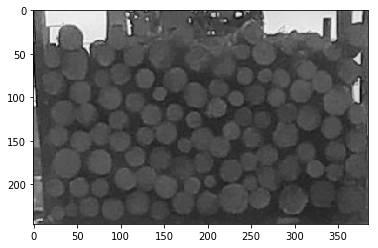

In [163]:
truck_image = imread("Madera/Buenas/2.jpg", as_gray=True)
plt.imshow(truck_image,cmap="gray")
print(truck_image.shape)

Aplicamos una función de umbral local (para mayor detalle)

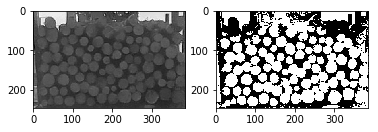

In [164]:
(gray_truck_image,binary_truck_image) = preprocessing(truck_image,'local')

Aplicamos dilatación (o erosión) para que los elementos de la imagen se expandan (o contraigan)

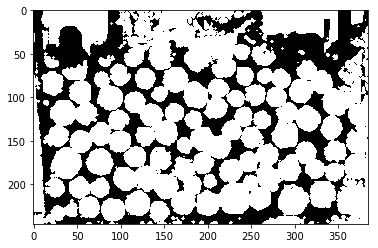

In [166]:
img=binary_truck_image
dil=binary_dilation(img)
#ero=binary_erosion(img)
img=dil #ero
plt.imshow(img, cmap='gray')

Ahora aplicamos una transformación de distancia euclideana. <br>
Esta transformación nos da un medida de la separación (usando distancia euclideana) de los puntos en la imagen.

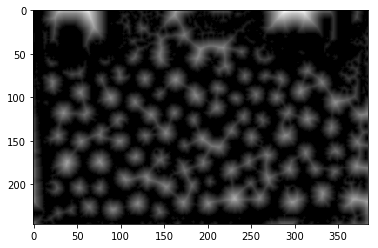

In [167]:
distance= ndi.distance_transform_edt(img)
plt.imshow(distance,cmap='gray')

A la imagen obtenida anteriormente le aplicamos una función umbral otsu (ya que no requerimos tanto detalle)

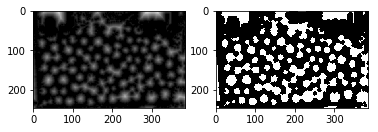

In [168]:
(gray_truck_image_2,binary_truck_image) = preprocessing(distance,'otsu')

Volvemos a aplicar la transformación de distancia euclideana, para que se ***** Troncos.


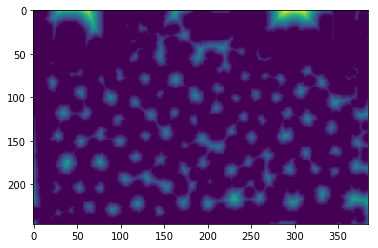

In [169]:
img=binary_truck_image
distance= ndi.distance_transform_edt(img)
plt.imshow(distance)

## Etiquetando la imagen para contar

Ahora que tenemos nuestros objetos separados trabajaremos en etiquetar cada uno. <br>
A continuación se toman los puntos maximos locales, y se te etiquetan para luego con la funcion watershed darles una etiqueta distinta


In [170]:
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                            labels=img)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=img)

Visualizacipón de los objetos separados y etiquetados

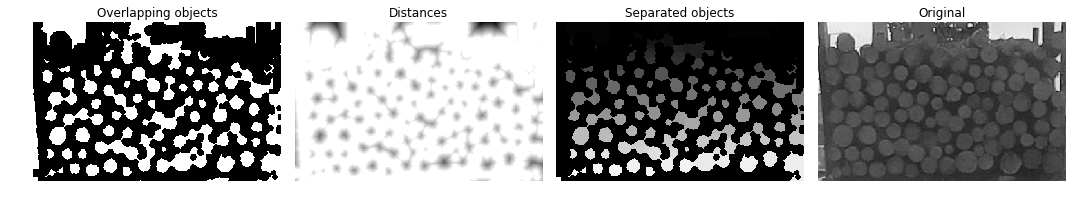

In [171]:
fig, axes = plt.subplots(ncols=4, figsize=(15, 10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(img, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap="gray", interpolation='nearest')
ax[2].set_title('Separated objects')
ax[3].imshow(truck_image, cmap="gray", interpolation='nearest')
ax[3].set_title('Original')
for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

Conteo de los troncos filtrando por area ocupada en la imagen

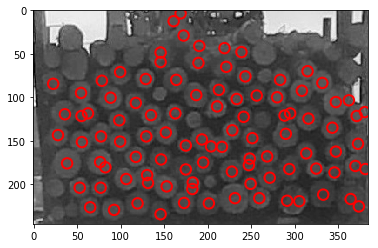

Cantidad de Troncos: 99


In [172]:
fig, (ax1) = plt.subplots(1)
ax1.imshow(gray_truck_image, cmap="gray");
i=0
# regionprops crea una lista con las propiedaes de todas las componentes conexas etiquetadas anteriormente
for region in regionprops(labels):
    if region.area > 1000:
        #Si la región es muy grande como para ser un Tronco la saltamos
        continue
    if region.area < 80:
        #Si la región es muy pequeña como para ser un Tronco la saltamos
        continue
    # Las coordenadas de los circulos
    minRow, minCol, maxRow, maxCol = region.bbox
    promCol=((minCol+maxCol)/2)
    promRow=((minRow+maxRow)/2)
    rectBorder = patches.Circle((promCol,promRow), radius=6, edgecolor="red", linewidth=2, fill=False)
    ax1.add_patch(rectBorder)
    i+=1
    # Dibujamos los circulos sobre los troncos
plt.show()

print("Cantidad de Troncos: " + str(i))